## Compare the triangulation obtained with Pose2Sim for various camera combinations

By: Léa Drolet-Roy

Last modification: 2025-07-25

In [21]:
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle, Patch

import seaborn as sns
import pandas as pd

import joblib
import itertools
from tqdm.autonotebook import tqdm

from compare_keypoints_3D import draw_skeleton

from data_analysis import extract_coordinates, load_2d_keypoints, plot_MPJPE_per_cam
from compute_CoM import CoM

In [22]:
cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141',
           'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461',
           'Camera7_M11462', 'Camera8_M11463']

# 2D
humans = ['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist',
          'Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'Rear', 'LEar']

vit = ['Nose', 'REye', 'LEye', 'REar', 'LEar', 'RShoulder', 'LShoulder', 'RElbow', 'LElbow', 'RWrist', 'LWrist',
       'RHip', 'LHip', 'RKnee', 'LKnee', 'RAnkle', 'LAnkle']

common_indices = [j for j in humans if j in vit]
matching_vit = [vit.index(j) for j in common_indices]
matching_humans = [humans.index(j) for j in common_indices]

# 3D
humans_3d = ['Hip', 'RHip', 'RKnee', 'RAnkle', 'RBigToe', 'RSmallToe', 'RHeel', 'LHip', 'LKnee', 'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel',
            'Neck', 'Nose', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']

vit_3d = ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Nose',
                'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']

common_indices_3d = [j for j in humans_3d if j in vit_3d]
matching_vit_3d = [vit_3d.index(j) for j in common_indices_3d]
matching_humans_3d = [humans_3d.index(j) for j in common_indices_3d]

In [23]:
def get_frame_name(model, frame_idx):
        if model == 'vit':
            frame_name = f'frame_{frame_idx:05d}_{frame_idx:06d}'
        elif model == '4dhumans':
            frame_name = f'frame_{frame_idx:06d}'
        return frame_name

def reformat_2d_points(points, matching_indices):
    pts = np.array(points)
    n_detections = pts.shape[0]
    pts = pts.reshape((n_detections, 2, -1))
    pts = pts[:, :, matching_indices]
    return pts

def compare_models_2d(cameras):
    source_vit = '/home/lea/trampo/Pose2Sim/pose_all_vit'
    triang_vit = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi'
        
    source_4dhumans = '/home/lea/trampo/Pose2Sim/pose_all_4dhumans'
    triang_4dhumans = '/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi'

    sequence_names = set(f.split('-')[0] for f in os.listdir(source_vit) if f in os.listdir(source_4dhumans))
    dist_per_cam = {}

    for cam_idx in range(8):
        cam_name = cameras[cam_idx]
        dist_per_cam.update({cam_name: {}})
        print(f'--- C{cam_idx+1} ---')
        
        dist = []
        
        # keypoints 2d cam i
        for seq in sorted(sequence_names):
            folder_name = f"{seq}-{cam_name}_json"
            src_path_vit = os.path.join(source_vit, folder_name)
            src_path_4dhumans = os.path.join(source_4dhumans, folder_name)

            # frames loop
            for frame_idx in range(0, len(os.listdir(src_path_vit))):
                # 2d - ViT
                frame_name = get_frame_name('vit', frame_idx)
                try:
                    vit_pts, _ = load_2d_keypoints(f'{src_path_vit}/{frame_name}.json')
                except FileNotFoundError:
                    continue
                
                if vit_pts is not None:
                    vit_pts = reformat_2d_points(vit_pts, matching_vit)
                else:
                    continue

                # 2d - 4DHumans
                frame_name = get_frame_name('4dhumans', frame_idx)
                try:
                    hum_pts, _ = load_2d_keypoints(f'{src_path_4dhumans}/{frame_name}.json')
                except FileNotFoundError:
                    continue
                
                if hum_pts is not None:
                    hum_pts = reformat_2d_points(hum_pts, matching_humans)
                else:
                    continue
                
                # distance 2d + filter on CoM position
                com_obj = CoM('women', 13)
                min_dist = np.full(vit_pts.shape[0], np.inf)
                for i in range(vit_pts.shape[0]):
                    vit_i = vit_pts[i]
                    com_vit = com_obj.compute_global_cm(vit_i)
                    for j in range(hum_pts.shape[0]):
                        hum_j = hum_pts[j]
                        dist_ij = np.linalg.norm(hum_j - vit_i, axis=0)
                        com_hum = com_obj.compute_global_cm(hum_j)

                        if np.linalg.norm(com_vit - com_hum) < 100 and np.mean(dist_ij) < np.mean(min_dist):
                            min_dist = dist_ij

                if min_dist.sum() != np.inf:        
                    dist.append(min_dist)
            
        dist_per_cam[cam_name] = dist

    return dist_per_cam

def plot_MPJPE_2d(MPJPE_per_cam, model, showNaN=False, ylim=False):
    n_best, n_worst = 4, 4

    labels = list(MPJPE_per_cam.keys())
    valeurs_list = list(MPJPE_per_cam.values())
    max_len = max(len(v) for v in valeurs_list)
    size = np.array(valeurs_list[0]).shape[-1]

    # Remplissage des valeurs avec NaN
    valeurs = np.full((len(valeurs_list), max_len * size), np.nan)
    for i, arr in enumerate(valeurs_list):
        r_arr = np.ravel(arr)
        valeurs[i, :len(r_arr)] = r_arr
    valeurs_sans_nan = [row[~np.isnan(row)] for row in valeurs]

    # Métriques
    nan_counts = np.isnan(valeurs).sum(axis=1)
    error_medians = np.nanmedian(valeurs, axis=1)
    error_q1 = np.nanquantile(valeurs, 0.25, axis=1)
    error_q3 = np.nanquantile(valeurs, 0.75, axis=1)
    error_maxiq = error_q3 + 1.5*(error_q3 - error_q1)

    if nan_counts.max() == 0:
        showNaN = False

    # --- Score combiné normalisé ---
    score = error_medians / error_medians.max()
    best_indices = np.argsort(score)[:n_best]
    worst_indices = np.argsort(score)[-n_worst:]

    # --- Création des axes ---
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Boxplot des erreurs (orange)
    bp = ax1.boxplot(valeurs_sans_nan, positions=np.arange(len(labels)),
                    patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('tab:blue')
    ax1.set_ylabel('Erreur 2D-MPJPE (px)', color='tab:blue', fontweight='bold')

    if not ylim:
        ax1.set_ylim(0, max(error_maxiq) * 1.05)
    else:
        ax1.set_ylim(0, ylim)

    if showNaN:
        ax2 = ax1.twinx()
        # Barres du nombre de NaN (bleu)
        bars = ax2.bar(np.arange(len(labels)), nan_counts, alpha=0.4,
                    color='skyblue', width=0.6)
        ax2.set_ylabel('Nombre total de points manquants (NaN)', color='skyblue', fontweight='bold')
        ax2.set_ylim(0, max(nan_counts) * 1.05)

        # --- Légende partagée ---
        legend_elements = [Patch(facecolor='tab:blue', label='Erreur 2D-MPJPE (px)'),
                        Patch(facecolor='skyblue', alpha=0.4, label='Nombre total de NaN')]
        ax1.legend(handles=legend_elements, loc='upper left')

    # --- Coloration des labels ---
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels, rotation=45)
    xticklabels = ax1.get_xticklabels()
    for idx in worst_indices:
        xticklabels[idx].set_color('red')
        xticklabels[idx].set_fontweight('bold')
    for idx in best_indices:
        xticklabels[idx].set_color('green')
        xticklabels[idx].set_fontweight('bold')

    # --- Grilles et titre ---
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Distance 2D entre les keypoints détectés par les 2 modèles')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/dist_{model}_filtCoM.png')
    plt.show()

def plot_MPJPE_2d_per_keypoint(MPJPE_per_cam, model, showNaN=False, ylim=False):
    n_best, n_worst = 4, 4
    
    # Liste fixe des keypoints
    keypoints = [
        'Nose', 'REye', 'LEye', 'LEar',
        'RShoulder', 'LShoulder', 'RElbow', 'LElbow',
        'RWrist', 'LWrist', 'RHip', 'LHip',
        'RKnee', 'LKnee', 'RAnkle', 'LAnkle'
    ]

    valeurs_list = list(MPJPE_per_cam.values())
    max_len = max(len(v) for v in valeurs_list)
    size = np.array(valeurs_list[0]).shape[-1]  # devrait être 16 = nb de keypoints

    # Remplissage des valeurs avec NaN
    valeurs = np.full((len(valeurs_list), max_len, size), np.nan)
    for i, arr in enumerate(valeurs_list):
        arr = np.array(arr)
        valeurs[i, :len(arr)] = arr

    # On concatène sur toutes les caméras et toutes les frames -> une série par keypoint
    valeurs_par_keypoint = []
    for k in range(size):
        data_k = valeurs[:, :, k].ravel()
        data_k = data_k[~np.isnan(data_k)]
        valeurs_par_keypoint.append(data_k)

    # Métriques par keypoint
    nan_counts = np.array([np.isnan(valeurs[:, :, k]).sum() for k in range(size)])
    error_medians = np.array([np.nanmedian(valeurs[:, :, k]) for k in range(size)])
    error_q1 = np.array([np.nanquantile(valeurs[:, :, k], 0.25) for k in range(size)])
    error_q3 = np.array([np.nanquantile(valeurs[:, :, k], 0.75) for k in range(size)])
    error_maxiq = error_q3 + 1.5*(error_q3 - error_q1)

    if nan_counts.max() == 0:
        showNaN = False

    # --- Score combiné normalisé ---
    score = error_medians / error_medians.max()
    best_indices = np.argsort(score)[:n_best]
    worst_indices = np.argsort(score)[-n_worst:]

    # --- Création des axes ---
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Boxplot par keypoint
    bp = ax1.boxplot(valeurs_par_keypoint, positions=np.arange(size),
                    patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('tab:blue')
    ax1.set_ylabel('Erreur 2D-MPJPE (px)', color='tab:blue', fontweight='bold')

    if not ylim:
        ax1.set_ylim(0, max(error_maxiq) * 1.05)
    else:
        ax1.set_ylim(0, ylim)

    if showNaN:
        ax2 = ax1.twinx()
        bars = ax2.bar(np.arange(size), nan_counts, alpha=0.4,
                    color='skyblue', width=0.6)
        ax2.set_ylabel('Nombre total de points manquants (NaN)', color='skyblue', fontweight='bold')
        ax2.set_ylim(0, max(nan_counts) * 1.05)

        legend_elements = [Patch(facecolor='tab:blue', label='Erreur 2D-MPJPE (px)'),
                           Patch(facecolor='skyblue', alpha=0.4, label='Nombre total de NaN')]
        ax1.legend(handles=legend_elements, loc='upper left')

    # --- Labels = keypoints ---
    ax1.set_xticks(np.arange(size))
    ax1.set_xticklabels(keypoints, rotation=90)
    xticklabels = ax1.get_xticklabels()
    for idx in worst_indices:
        xticklabels[idx].set_color('red')
        xticklabels[idx].set_fontweight('bold')
    for idx in best_indices:
        xticklabels[idx].set_color('green')
        xticklabels[idx].set_fontweight('bold')

    # --- Grilles et titre ---
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Distance 2D entre les keypoints détectés par les 2 modèles')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/dist_{model}_filtCoM_parKeypoint.png')
    plt.show()

In [24]:
dist_per_cam = compare_models_2d(cameras)

--- C1 ---
--- C2 ---
--- C3 ---
--- C4 ---
--- C5 ---
--- C6 ---
--- C7 ---
--- C8 ---


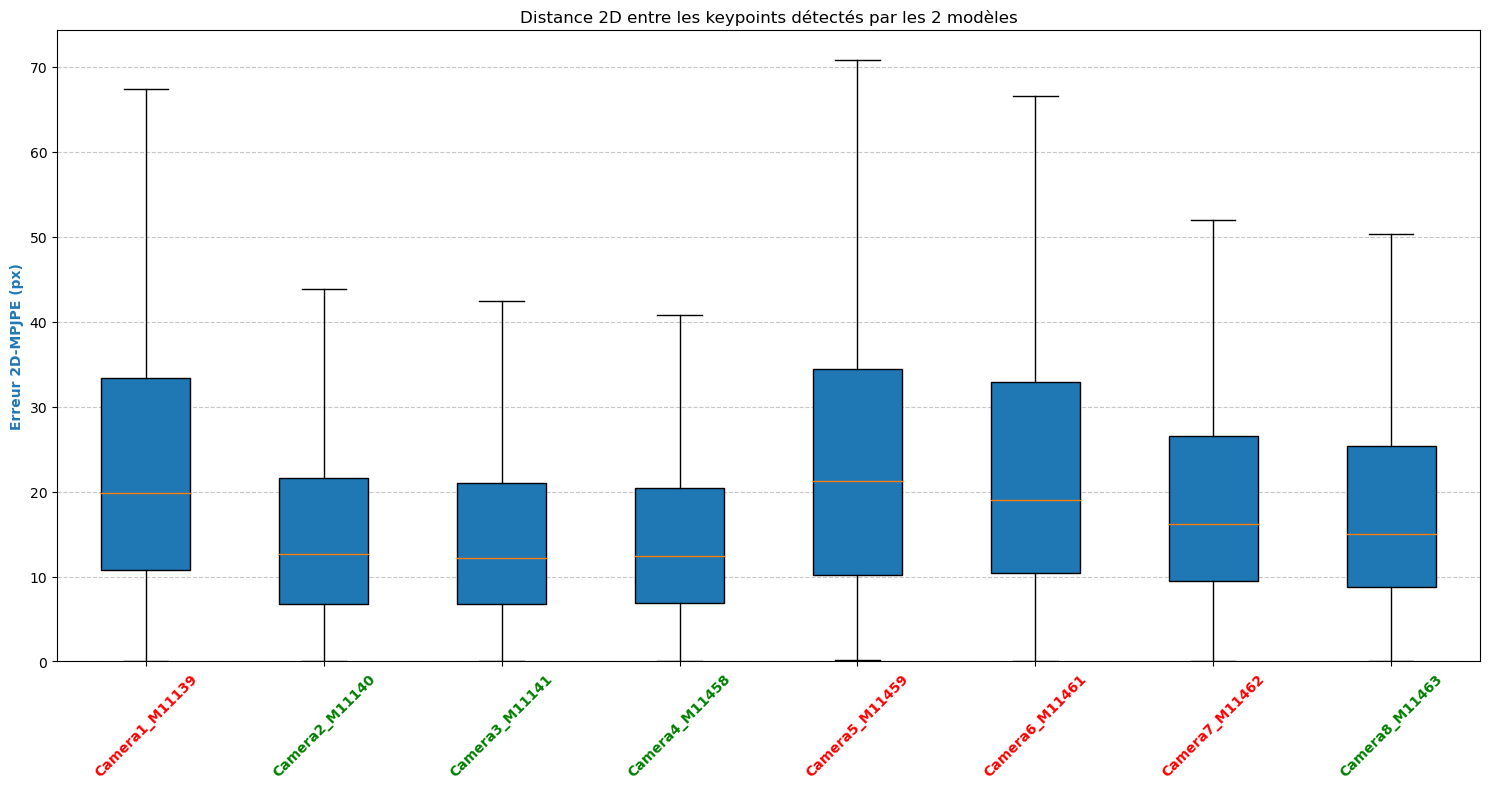

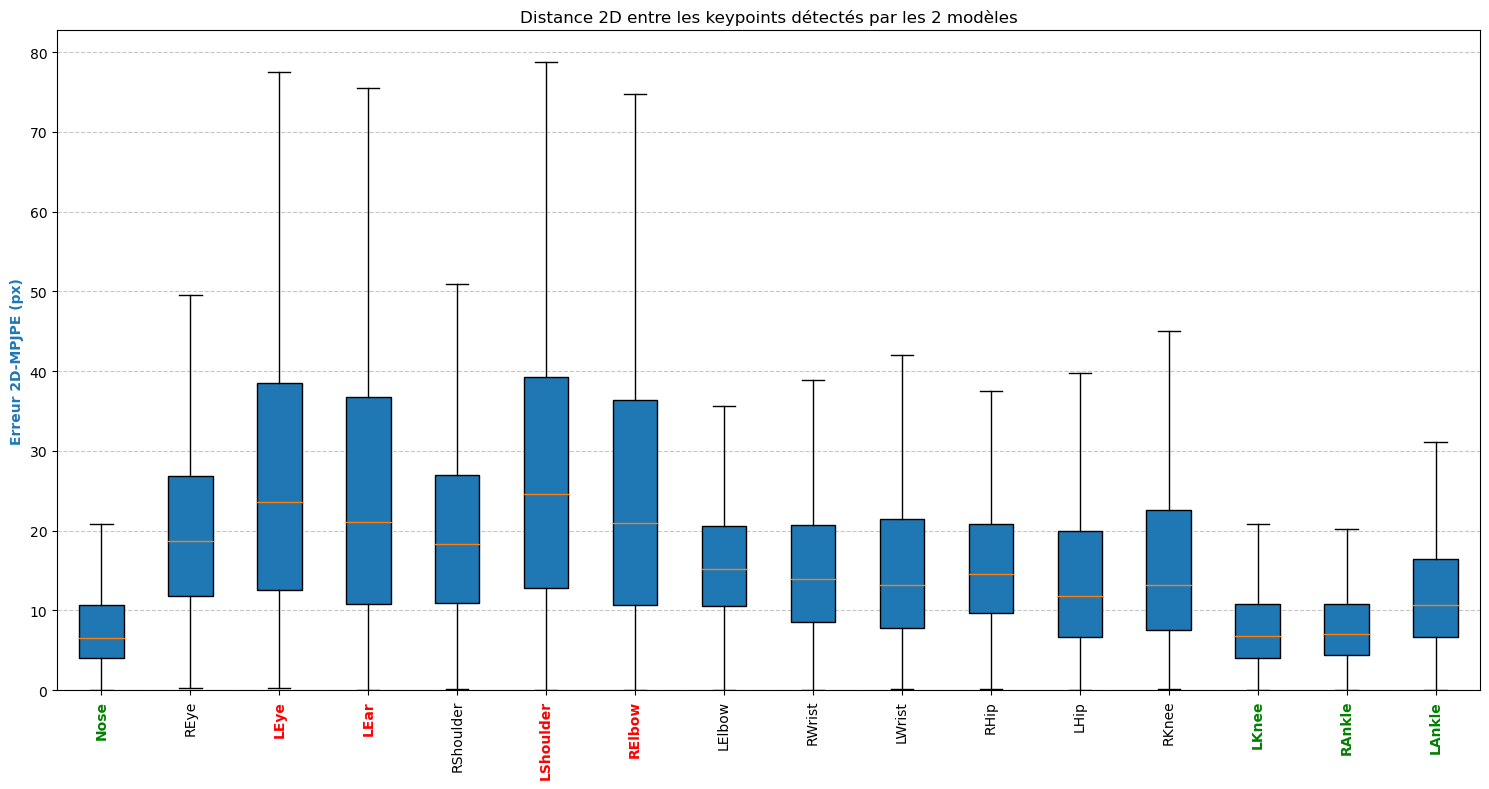

In [25]:
plot_MPJPE_2d(dist_per_cam, 'vit+4dhumans')
plot_MPJPE_2d_per_keypoint(dist_per_cam, 'vit+4dhumans')

In [26]:
def compare_models_3d(cameras, threshold_cm=1000):
    source_vit = '/home/lea/trampo/Pose2Sim/pose_all_vit'
    triang_vit = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi'
    triang_4dhumans = '/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi'

    sequence_names = set(f.split('-')[0] for f in os.listdir(source_vit))
    dist_per_cam = {}

    for cam_combination in tqdm(itertools.combinations(enumerate(cameras), 4)):
        cam_indices, cam_names = zip(*cam_combination)
        cam_label = '+'.join(f"C{idx+1}" for idx in cam_indices)  # Label like C1+C3+C5
        dist_per_cam.update({cam_label:[]})
        dist = []

        for seq in sorted(sequence_names):
            folder_name = f"{seq}-{cameras[0]}_json"
            src_path_vit = os.path.join(source_vit, folder_name)

            #keypoints 3d
            triang_path = os.path.join(triang_vit, seq, cam_label, f'{seq}.trc')
            try:
                triang_points_vit, frames_vit = extract_coordinates(triang_path)
            except FileNotFoundError:
                continue
            triang_path = os.path.join(triang_4dhumans, seq, cam_label, f'{seq}.trc')
            try:
                triang_points_hum, frames_hum = extract_coordinates(triang_path)
            except FileNotFoundError:
                continue

            # frames loop
            for frame_idx in range(0, len(os.listdir(src_path_vit)), 5):
                coords_vit = triang_points_vit[np.where(frames_vit == frame_idx)].reshape((-1, 3))
                if len(coords_vit) > 0:
                    coords_vit = coords_vit[matching_vit_3d]
                else:
                    continue
                coords_hum = triang_points_hum[np.where(frames_hum == frame_idx)].reshape((-1, 3))
                if len(coords_hum) > 0:
                    coords_hum = coords_hum[matching_humans_3d]
                else:
                    continue

                # distance 2d + filter on CoM position
                com_obj = CoM('women', 13)
                com_vit = com_obj.compute_global_cm(coords_vit)
                com_hum = com_obj.compute_global_cm(coords_hum)
                
                dist_ij = np.linalg.norm(coords_hum - coords_vit, axis=1)

                if np.linalg.norm(com_vit - com_hum) < threshold_cm:    
                    dist.append(dist_ij)
                    
            dist_per_cam[cam_label] = dist
    return dist_per_cam

def plot_MPJPE_combis(dist_per_cam, model, showNaN=False, ylim=False):
    n_best, n_worst = 4, 4  # nombre de meilleures/pire combinaisons à mettre en évidence

    labels = list(dist_per_cam.keys())
    valeurs_list = list(dist_per_cam.values())

    # Aplatir et enlever les NaN
    valeurs_sans_nan = [np.ravel(v)[~np.isnan(np.ravel(v))] for v in valeurs_list]

    # Construire une matrice "rectangulaire" remplie de NaN pour stats par ligne
    max_len = max(len(v) for v in valeurs_sans_nan)
    valeurs = np.full((len(valeurs_sans_nan), max_len), np.nan, dtype=np.float32)
    for i, arr in enumerate(valeurs_sans_nan):
        valeurs[i, :len(arr)] = arr

    # --- Métriques ---
    nan_counts = np.isnan(valeurs).sum(axis=1)
    error_medians = np.nanmedian(valeurs, axis=1)
    error_q1 = np.nanquantile(valeurs, 0.25, axis=1)
    error_q3 = np.nanquantile(valeurs, 0.75, axis=1)
    error_maxiq = error_q3 + 1.5 * (error_q3 - error_q1)

    # Score combiné (normalisé sur la médiane)
    score = error_medians / np.nanmax(error_medians)
    best_indices = np.argsort(score)[:n_best]
    worst_indices = np.argsort(score)[-n_worst:]

    # --- Création des axes ---
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Boxplot des erreurs
    bp = ax1.boxplot(valeurs_sans_nan, positions=np.arange(len(labels)),
                    patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('tab:blue')
    ax1.set_ylabel('Erreur 3D-MPJPE (mm)', color='tab:blue', fontweight='bold')

    if not ylim:
        ax1.set_ylim(0, np.nanmax(error_maxiq) * 1.05)
    else:
        ax1.set_ylim(0, ylim)

    # --- Affichage du nombre de NaN ---
    if showNaN and nan_counts.max() > 0:
        ax2 = ax1.twinx()
        bars = ax2.bar(np.arange(len(labels)), nan_counts, alpha=0.4,
                    color='skyblue', width=0.6)
        ax2.set_ylabel('Nombre total de NaN', color='skyblue', fontweight='bold')
        ax2.set_ylim(0, max(nan_counts) * 1.05)

        # Légende combinée
        legend_elements = [
            Patch(facecolor='tab:blue', label='Erreur 3D-MPJPE (mm)'),
            Patch(facecolor='skyblue', alpha=0.4, label='Nombre total de NaN')
        ]
        ax1.legend(handles=legend_elements, loc='upper left')

    # --- Coloration des labels ---
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels, rotation=90)
    xticklabels = ax1.get_xticklabels()
    for idx in worst_indices:
        xticklabels[idx].set_color('red')
        xticklabels[idx].set_fontweight('bold')
    for idx in best_indices:
        xticklabels[idx].set_color('green')
        xticklabels[idx].set_fontweight('bold')

    # --- Grilles et titre ---
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Distance 3D entre modèles par combinaison de 4 caméras')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/dist_{model}_3D_per_combination.png')
    plt.show()


def plot_MPJPE_3d_per_keypoint(MPJPE_per_cam, model, showNaN=False, ylim=False):
    n_best, n_worst = 4, 4
    
    # Liste fixe des keypoints
    keypoints = ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Nose',
                 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']

    valeurs_list = list(MPJPE_per_cam.values())
    max_len = max(len(v) for v in valeurs_list)
    size = np.array(valeurs_list[0]).shape[-1]  # devrait être 16 = nb de keypoints

    # Remplissage des valeurs avec NaN
    valeurs = np.full((len(valeurs_list), max_len, size), np.nan)
    for i, arr in enumerate(valeurs_list):
        arr = np.array(arr)
        valeurs[i, :len(arr)] = arr

    # On concatène sur toutes les caméras et toutes les frames -> une série par keypoint
    valeurs_par_keypoint = []
    for k in range(size):
        data_k = valeurs[:, :, k].ravel()
        data_k = data_k[~np.isnan(data_k)]
        valeurs_par_keypoint.append(data_k)

    # Métriques par keypoint
    nan_counts = np.array([np.isnan(valeurs[:, :, k]).sum() for k in range(size)])
    error_medians = np.array([np.nanmedian(valeurs[:, :, k]) for k in range(size)])
    error_q1 = np.array([np.nanquantile(valeurs[:, :, k], 0.25) for k in range(size)])
    error_q3 = np.array([np.nanquantile(valeurs[:, :, k], 0.75) for k in range(size)])
    error_maxiq = error_q3 + 1.5*(error_q3 - error_q1)

    if nan_counts.max() == 0:
        showNaN = False

    # --- Score combiné normalisé ---
    score = error_medians / error_medians.max()
    best_indices = np.argsort(score)[:n_best]
    worst_indices = np.argsort(score)[-n_worst:]

    # --- Création des axes ---
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Boxplot par keypoint
    bp = ax1.boxplot(valeurs_par_keypoint, positions=np.arange(size),
                    patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('tab:blue')
    ax1.set_ylabel('Erreur 3D-MPJPE (mm)', color='tab:blue', fontweight='bold')

    if not ylim:
        ax1.set_ylim(0, max(error_maxiq) * 1.05)
    else:
        ax1.set_ylim(0, ylim)

    if showNaN:
        ax2 = ax1.twinx()
        bars = ax2.bar(np.arange(size), nan_counts, alpha=0.4,
                    color='skyblue', width=0.6)
        ax2.set_ylabel('Nombre total de points manquants (NaN)', color='skyblue', fontweight='bold')
        ax2.set_ylim(0, max(nan_counts) * 1.05)

        legend_elements = [Patch(facecolor='tab:blue', label='Erreur 3D-MPJPE (mm)'),
                           Patch(facecolor='skyblue', alpha=0.4, label='Nombre total de NaN')]
        ax1.legend(handles=legend_elements, loc='upper left')

    # --- Labels = keypoints ---
    ax1.set_xticks(np.arange(size))
    ax1.set_xticklabels(keypoints, rotation=90)
    xticklabels = ax1.get_xticklabels()
    for idx in worst_indices:
        xticklabels[idx].set_color('red')
        xticklabels[idx].set_fontweight('bold')
    for idx in best_indices:
        xticklabels[idx].set_color('green')
        xticklabels[idx].set_fontweight('bold')

    # --- Grilles et titre ---
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Distance 3D entre les keypoints détectés par les 2 modèles')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/dist_{model}_filtCoM_parKeypoint.png')
    plt.show()

In [27]:
dist_per_cam = compare_models_3d(cameras, 500)

0it [00:00, ?it/s]

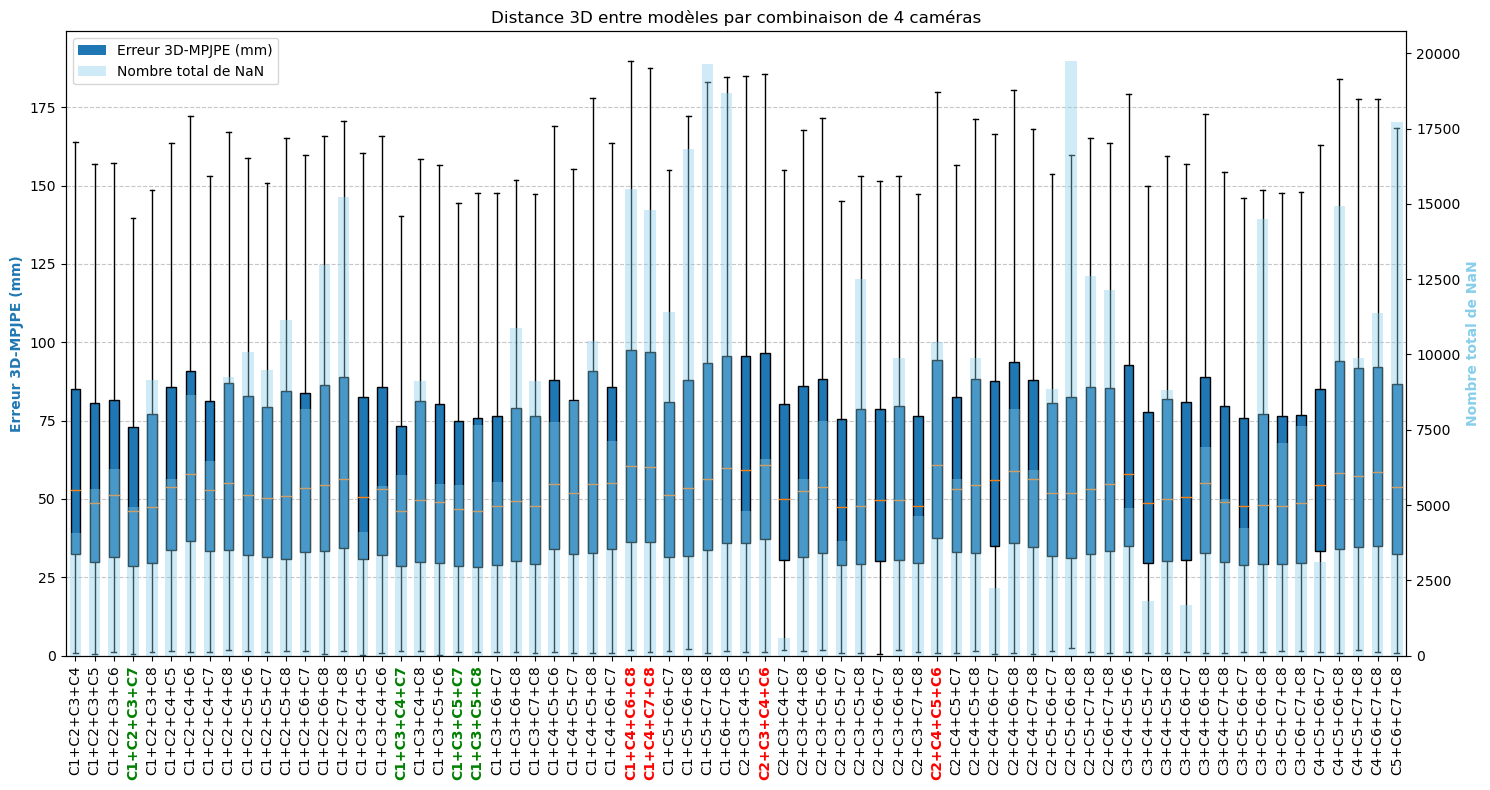

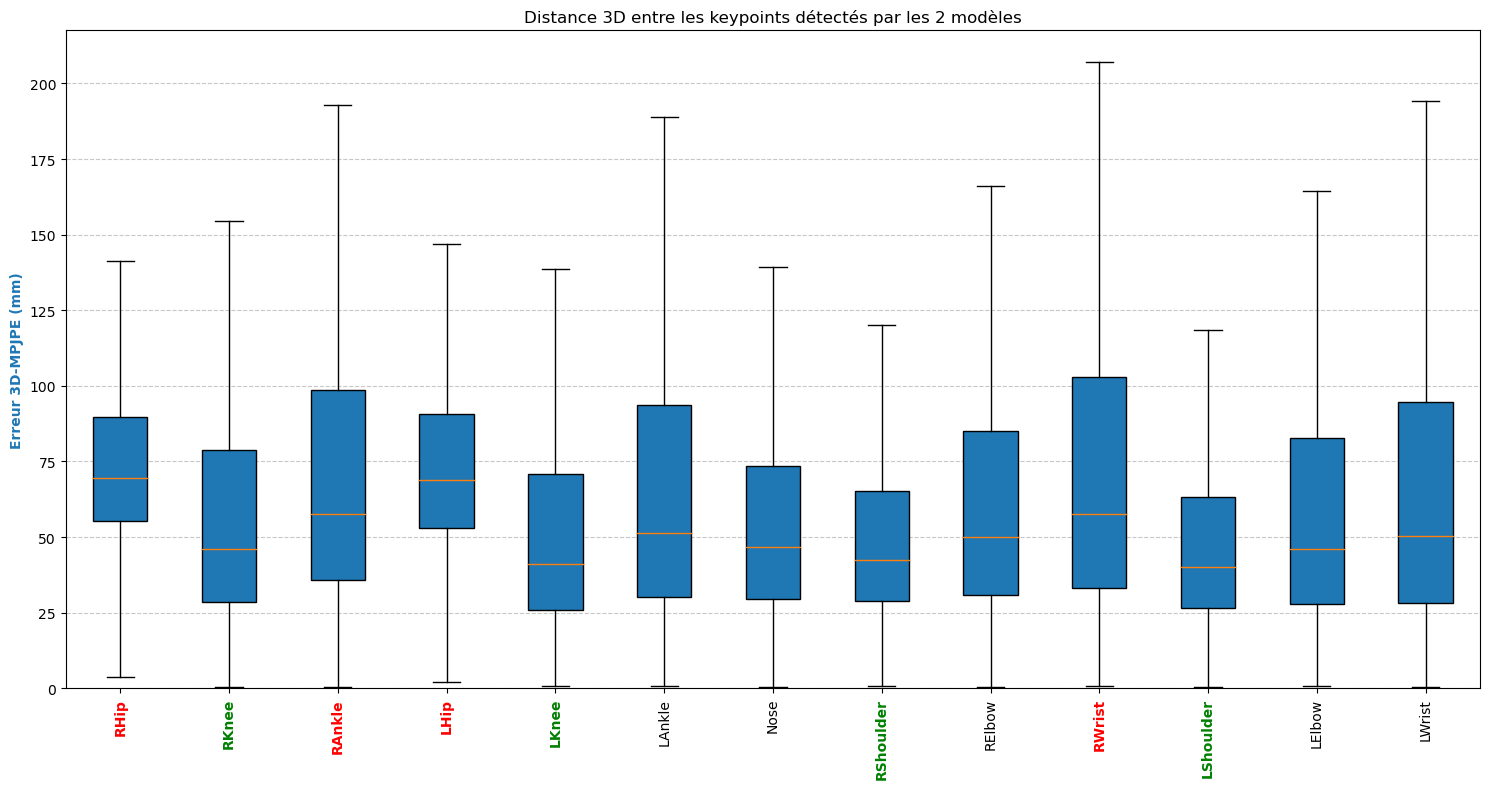

In [28]:
plot_MPJPE_combis(dist_per_cam, 'vit+4dhumans', showNaN=True)
plot_MPJPE_3d_per_keypoint(dist_per_cam, 'vit+4dhumans')

In [29]:
from data_analysis import get_stats, get_all_error_stats

toutes_valeurs_global = np.concatenate([vals for vals in dist_per_cam.values()])
stats_globales = get_stats(toutes_valeurs_global)

print('GLOBAL')
print(stats_globales)

GLOBAL
{'moyenne': 67.4726519666115, 'médiane': 52.30666178784338, 'écart_type': 55.524169946405316, 'q1': 31.767542564101397, 'q3': 83.92890846248605, 'max': 970.8750110971871}


In [40]:
def compare_models_3d_Ncams(cameras, threshold_cm):
    source_vit = '/home/lea/trampo/Pose2Sim/pose_all_vit'
    triang_vit = '/home/lea/trampo/Pose2Sim/pose-3d-vit-multi'
    triang_4dhumans = '/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi'

    sequence_names = set(f.split('-')[0] for f in os.listdir(source_vit))
    dist_per_cam = {}

    for N in range(2, 8):
        dist_per_cam.update({N:{}})

        for cam_combination in tqdm(itertools.combinations(enumerate(cameras), N)):
            cam_indices, cam_names = zip(*cam_combination)
            cam_label = '+'.join(f"C{idx+1}" for idx in cam_indices)  # Label like C1+C3+C5
            dist_per_cam[N].update({cam_label:[]})
            dist = []

            for seq in sorted(sequence_names):
                folder_name = f"{seq}-{cameras[0]}_json"
                src_path_vit = os.path.join(source_vit, folder_name)

                #keypoints 3d
                triang_path = os.path.join(triang_vit, seq, cam_label, f'{seq}.trc')
                try:
                    triang_points_vit, frames_vit = extract_coordinates(triang_path)
                except FileNotFoundError:
                    continue
                triang_path = os.path.join(triang_4dhumans, seq, cam_label, f'{seq}.trc')
                try:
                    triang_points_hum, frames_hum = extract_coordinates(triang_path)
                except FileNotFoundError:
                    continue

                # frames loop
                for frame_idx in range(0, len(os.listdir(src_path_vit)), 5):
                    coords_vit = triang_points_vit[np.where(frames_vit == frame_idx)].reshape((-1, 3))
                    if len(coords_vit) > 0:
                        coords_vit = coords_vit[matching_vit_3d]
                    else:
                        continue
                    coords_hum = triang_points_hum[np.where(frames_hum == frame_idx)].reshape((-1, 3))
                    if len(coords_hum) > 0:
                        coords_hum = coords_hum[matching_humans_3d]
                    else:
                        continue

                    # distance 2d + filter on CoM position
                    com_obj = CoM('women', 13)
                    com_vit = com_obj.compute_global_cm(coords_vit)
                    com_hum = com_obj.compute_global_cm(coords_hum)
                    
                    dist_ij = np.linalg.norm(coords_hum - coords_vit, axis=1)

                    if np.linalg.norm(com_vit - com_hum) < threshold_cm:    
                        dist.append(dist_ij)
                        
                dist_per_cam[N][cam_label] = dist
    return dist_per_cam

def plot_MPJPE_by_ncams(dist_ncams, model, showNaN=False, ylim=False):
    # --- Fusionner toutes les combinaisons pour chaque n_cams ---
    grouped = {}
    for n_cams, combis in dist_ncams.items():  # combis = dict des combinaisons
        all_vals = []
        for vals in combis.values():
            arr = np.array(vals, dtype=float).ravel()
            arr = arr[~np.isnan(arr)]
            if len(arr) > 0:
                all_vals.append(arr)
        if len(all_vals) > 0:
            grouped[n_cams] = np.concatenate(all_vals)

    labels = sorted(grouped.keys())
    valeurs_sans_nan = [grouped[n] for n in labels]

    # --- Métriques ---
    error_medians = [np.median(v) for v in valeurs_sans_nan]
    error_q1 = [np.quantile(v, 0.25) for v in valeurs_sans_nan]
    error_q3 = [np.quantile(v, 0.75) for v in valeurs_sans_nan]
    error_maxiq = [q3 + 1.5*(q3-q1) for q1, q3 in zip(error_q1, error_q3)]

    # --- Création du plot ---
    fig, ax = plt.subplots(figsize=(9,5))
    bp = ax.boxplot(valeurs_sans_nan, positions=np.arange(len(labels)),
                    patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('tab:blue')

    ax.set_ylabel("Erreur 3D-MPJPE (mm)", fontweight="bold")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels([str(l) for l in labels], fontweight="bold")
    ax.set_xlabel("Nombre de caméras dans la combinaison", fontweight="bold")

    if not ylim:
        ax.set_ylim(0, max(error_maxiq) * 1.05)
    else:
        ax.set_ylim(0, ylim)

    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.set_title(f"Erreur 3D entre modèles selon le nombre de caméras")

    plt.tight_layout()
    plt.savefig(f"/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/dist_{model}_3D_by_ncams.png")
    plt.show()



In [39]:
dist_ncams = compare_models_3d_Ncams(cameras, 10000)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

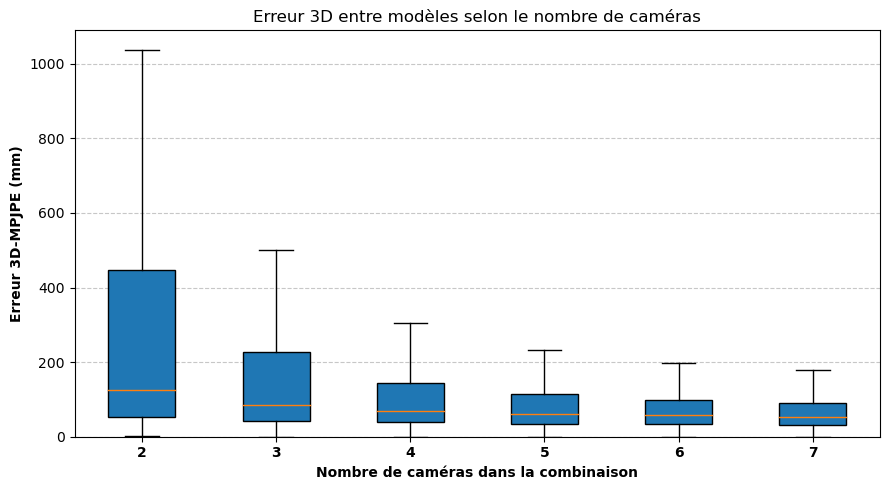

In [41]:
plot_MPJPE_by_ncams(dist_ncams, 'vit+4dhumans')

In [33]:
stats_globales = get_all_error_stats(dist_ncams)

print('GLOBAL')
print(stats_globales)


--- Stats par combinaison ---
2
  C1+C2: {'moyenne': 95.25997487263295, 'médiane': 65.35238605071132, 'écart_type': 87.3359318586433, 'q1': 39.49170971303073, 'q3': 118.30171056376174, 'max': 763.1365802792388}
  C1+C3: {'moyenne': 90.88342820087146, 'médiane': 55.67564698056546, 'écart_type': 104.80092555615994, 'q1': 31.454085479946983, 'q3': 103.75378102882178, 'max': 1201.589976162908}
  C1+C4: {'moyenne': 94.53986470349696, 'médiane': 66.13566624101912, 'écart_type': 94.52930182426837, 'q1': 38.120689195118175, 'q3': 114.9239029857943, 'max': 1446.6459444317927}
  C1+C5: {'moyenne': 97.41186395922982, 'médiane': 60.8795722062953, 'écart_type': 96.75387652089327, 'q1': 35.038869679693484, 'q3': 126.53411054195027, 'max': 1535.2909790523936}
  C1+C6: {'moyenne': 78.67253085532228, 'médiane': 54.550891461372295, 'écart_type': 82.75274278721403, 'q1': 32.15520013003053, 'q3': 95.04909013318023, 'max': 1090.483870221302}
  C1+C7: {'moyenne': 102.07148273788253, 'médiane': 72.320872653

In [34]:
# TODO: PA-MPJPE between models !!!